# Animal Classification

Author: Tammie Koh

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define paths to your dataset directories
base_dir = 'dataset_animals'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'

In [3]:
# Initialize the ImageDataGenerator for the training set with normalization
train_datagen = ImageDataGenerator(rescale=1./255)

# Similarly, initialize the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
batch_size = 32

# Load images from the directories
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the target directory
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # Since we use categorical_crossentropy loss, we need categorical labels

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 6495 images belonging to 5 classes.
Found 1701 images belonging to 5 classes.


In [5]:
# Step 2: Define the CNN architecture
model = models.Sequential([
    layers.InputLayer(shape=(150, 150, 3)),  # Adjust input shape as necessary, assuming images are resized to 150x150
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')
])

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


Epoch 1/10


/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.2603 - loss: 1.5725 - val_accuracy: 0.3037 - val_loss: 1.5246
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.4062 - loss: 0.6576 - val_accuracy: 0.6000 - val_loss: 0.8687
Epoch 3/10


2024-03-30 14:35:34.683235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 14:35:34.698501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.3767 - loss: 1.4183 - val_accuracy: 0.3962 - val_loss: 1.4093
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - accuracy: 0.4062 - loss: 0.7164 - val_accuracy: 0.4000 - val_loss: 0.6812
Epoch 5/10


2024-03-30 14:36:15.548279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 14:36:15.560098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 42s 207ms/step - accuracy: 0.4248 - loss: 1.3675 - val_accuracy: 0.4210 - val_loss: 1.3985
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.3438 - loss: 0.7212 - val_accuracy: 0.4000 - val_loss: 0.4691
Epoch 7/10


2024-03-30 14:36:57.800999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 14:36:57.814622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - accuracy: 0.4361 - loss: 1.3329 - val_accuracy: 0.4381 - val_loss: 1.3538
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 115us/step - accuracy: 0.5000 - loss: 0.6244 - val_accuracy: 1.0000 - val_loss: 0.4843
Epoch 9/10


2024-03-30 14:37:42.317716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 14:37:42.332850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - accuracy: 0.4616 - loss: 1.2994 - val_accuracy: 0.4062 - val_loss: 1.3674
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - accuracy: 0.4062 - loss: 0.6432 - val_accuracy: 0.4000 - val_loss: 0.6554


2024-03-30 14:38:28.001199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 14:38:28.015516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


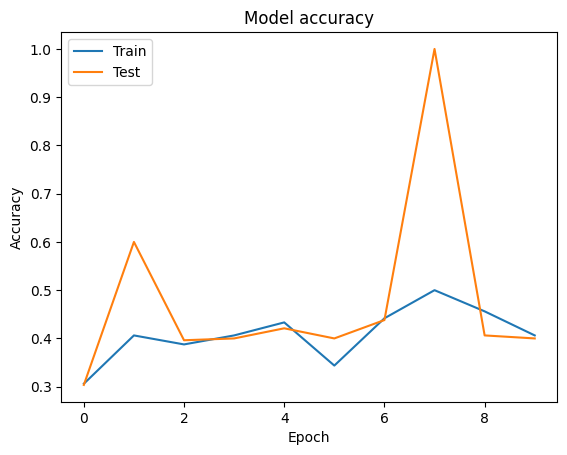

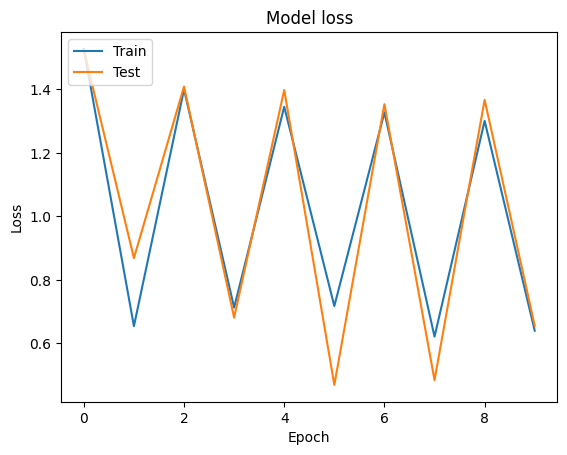

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Training Performance: The accuracy on the training set appears to fluctuate quite a bit from epoch to epoch. This might indicate that the model is not learning consistently, possibly due to a small dataset size, too high a learning rate, or other factors.

Generalization Gap: There is a noticeable difference between training and test accuracy, which suggests overfitting. Even though the training accuracy isn't very high, it's consistently above the test accuracy. The model is learning patterns specific to the training set that do not generalize well to the test set.

Loss Fluctuations: Similarly, the loss for both training and test data fluctuates significantly. Ideally, you'd like to see a smooth, downward trend in loss as training progresses, which would indicate that the model is learning effectively.

Test Accuracy: A test accuracy of approximately 46.34% indicates that the model performs relatively poorly on the test set. Given that there are 5 classes, this is not much better than random guessing, which would be 20% accuracy for a balanced dataset.

In [8]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3829 - loss: 1.4446
Test accuracy: 0.3932783007621765


A test accuracy of approximately 46.34% indicates that the model performs relatively poorly on the test set. Given that there are 5 classes, this is not much better than random guessing, which would be 20% accuracy for a balanced dataset.

In [9]:
train_classes = train_generator.classes
class_indices = train_generator.class_indices

# Count the number of occurrences of each class in the training set
class_counts = {class_name: 0 for class_name in class_indices.keys()}

for class_index in train_classes:
    class_name = [class_name for class_name, index in class_indices.items() if index == class_index][0]
    class_counts[class_name] += 1

print(class_counts)


{'butterfly': 1539, 'cow': 1359, 'elephant': 1006, 'sheep': 1302, 'squirrel': 1289}


This is more or less a balanced dataset. We can look to ways to improve this performance by using transfer learning.

## 1. Data Augmentation

In [10]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the data generators
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6495 images belonging to 5 classes.


In [11]:
def create_model(base_model):
    base_model.trainable = False  # Freeze the layers of the pre-trained model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)  # Assuming we have 5 classes
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Initialize pre-trained models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Create models
vgg16_model = create_model(vgg16_base)
resnet50_model = create_model(resnet50_base)
mobilenetv2_model = create_model(mobilenetv2_base)

/var/folders/j3/2xy_ffxd6jq618phh49pk1b00000gn/T/ipykernel_27361/4006250.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Without augmentation

In [13]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.6411 - loss: 0.8794 - val_accuracy: 0.8331 - val_loss: 0.4637
Epoch 2/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.7812 - loss: 0.4945

2024-03-30 14:48:39.166417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 0.2485 - val_accuracy: 0.8000 - val_loss: 0.1789
Epoch 3/10


2024-03-30 14:48:39.474601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.8277 - loss: 0.4643 - val_accuracy: 0.8479 - val_loss: 0.4098
Epoch 4/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 8:06 2s/step - accuracy: 0.9062 - loss: 0.3119

2024-03-30 14:58:42.781985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9062 - loss: 0.1567 - val_accuracy: 1.0000 - val_loss: 0.0376
Epoch 5/10


2024-03-30 14:58:43.254582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.8527 - loss: 0.3888 - val_accuracy: 0.8544 - val_loss: 0.3897
Epoch 6/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 7:27 2s/step - accuracy: 0.8438 - loss: 0.4678

2024-03-30 15:08:14.982838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8438 - loss: 0.2350 - val_accuracy: 1.0000 - val_loss: 0.0382
Epoch 7/10


2024-03-30 15:08:15.403162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.8539 - loss: 0.3710 - val_accuracy: 0.8656 - val_loss: 0.3772
Epoch 8/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:55 2s/step - accuracy: 0.8750 - loss: 0.3313

2024-03-30 15:17:43.878996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.1665 - val_accuracy: 0.8000 - val_loss: 0.3846
Epoch 9/10


2024-03-30 15:17:44.250247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 527s 3s/step - accuracy: 0.8751 - loss: 0.3408 - val_accuracy: 0.8608 - val_loss: 0.4024
Epoch 10/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.9062 - loss: 0.2788

2024-03-30 15:26:33.535119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.1401 - val_accuracy: 0.8000 - val_loss: 0.1633


2024-03-30 15:26:33.849075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [14]:
history_vgg16_augmented = vgg16_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

#TODO: initialise the steps and validation steps

# steps_per_epoch = train_generator.samples // batch_size
# validation_steps = test_generator.samples // batch_size

# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10,
#     validation_data=test_generator,
#     validation_steps=validation_steps
# )

Epoch 1/10


/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.7888 - loss: 0.5565 - val_accuracy: 0.8662 - val_loss: 0.3701
Epoch 2/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:42 2s/step - accuracy: 0.8750 - loss: 0.4202

2024-03-30 15:34:41.067638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/tammiekoh/miniconda3/envs/ML_lecture_2/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.2111 - val_accuracy: 1.0000 - val_loss: 0.0429
Epoch 3/10


2024-03-30 15:34:41.408901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.8133 - loss: 0.4919 - val_accuracy: 0.8597 - val_loss: 0.3683
Epoch 4/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:33 2s/step - accuracy: 0.9375 - loss: 0.2882

2024-03-30 15:43:56.809981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1448 - val_accuracy: 0.8000 - val_loss: 0.1704
Epoch 5/10


2024-03-30 15:43:57.183253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.8249 - loss: 0.4710 - val_accuracy: 0.8526 - val_loss: 0.3827
Epoch 6/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 6:46 2s/step - accuracy: 0.8438 - loss: 0.3060

2024-03-30 15:53:15.119076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.1538 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 7/10


2024-03-30 15:53:15.487045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.8490 - loss: 0.4170 - val_accuracy: 0.8756 - val_loss: 0.3468
Epoch 8/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 7:13 2s/step - accuracy: 0.8438 - loss: 0.4218

2024-03-30 16:02:32.748202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8438 - loss: 0.2120 - val_accuracy: 1.0000 - val_loss: 0.0785
Epoch 9/10


2024-03-30 16:02:33.087932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2987s 15s/step - accuracy: 0.8206 - loss: 0.4539 - val_accuracy: 0.8514 - val_loss: 0.3938
Epoch 10/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 4:18 1s/step - accuracy: 0.8125 - loss: 0.4530

2024-03-30 16:52:21.642228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8125 - loss: 0.2276 - val_accuracy: 0.8000 - val_loss: 0.1380


2024-03-30 16:52:21.896633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [15]:
history_resnet50 = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 7459s 37s/step - accuracy: 0.3124 - loss: 1.5626 - val_accuracy: 0.4735 - val_loss: 1.3133
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.5000 - loss: 0.6605 - val_accuracy: 0.6000 - val_loss: 0.6058
Epoch 3/10


2024-03-30 18:56:41.908947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:56:42.020073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 2517s 13s/step - accuracy: 0.4274 - loss: 1.3619 - val_accuracy: 0.4841 - val_loss: 1.2500
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.4375 - loss: 0.6738 - val_accuracy: 0.4000 - val_loss: 0.5974
Epoch 5/10


2024-03-30 19:38:39.297329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:38:39.391044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 3145s 16s/step - accuracy: 0.4845 - loss: 1.2640 - val_accuracy: 0.5371 - val_loss: 1.1744
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.5938 - loss: 0.5819 - val_accuracy: 0.6000 - val_loss: 0.5103
Epoch 7/10


2024-03-30 20:31:05.092113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:31:05.204572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 1141s 6s/step - accuracy: 0.5088 - loss: 1.1977 - val_accuracy: 0.5419 - val_loss: 1.1339
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.4688 - loss: 0.6247 - val_accuracy: 0.6000 - val_loss: 0.5053
Epoch 9/10


2024-03-30 20:50:06.729305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:50:06.841489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 167s 826ms/step - accuracy: 0.5332 - loss: 1.1401 - val_accuracy: 0.4446 - val_loss: 1.2917
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.5625 - loss: 0.5276 - val_accuracy: 0.2000 - val_loss: 0.7703


2024-03-30 20:52:54.417501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:52:54.548459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
history_resnet50_augmented = resnet50_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 167s 825ms/step - accuracy: 0.4426 - loss: 1.3317 - val_accuracy: 0.5849 - val_loss: 1.0935
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.2188 - loss: 0.7949 - val_accuracy: 1.0000 - val_loss: 0.3816
Epoch 3/10


2024-03-30 20:55:42.758037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:55:42.883420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 164s 810ms/step - accuracy: 0.4245 - loss: 1.3475 - val_accuracy: 0.5513 - val_loss: 1.1444
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.4062 - loss: 0.7539 - val_accuracy: 0.4000 - val_loss: 0.5175
Epoch 5/10


2024-03-30 20:58:28.047783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:58:28.178520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 188s 926ms/step - accuracy: 0.4422 - loss: 1.3363 - val_accuracy: 0.5094 - val_loss: 1.1957
Epoch 6/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 2:15 673ms/step - accuracy: 0.4688 - loss: 1.3608

2024-03-30 21:01:36.721497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:01:36.906140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 0.6838 - val_accuracy: 0.4000 - val_loss: 0.4220
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 199s 982ms/step - accuracy: 0.4564 - loss: 1.3114 - val_accuracy: 0.5643 - val_loss: 1.1136
Epoch 8/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 2:34 769ms/step - accuracy: 0.4375 - loss: 1.1585

2024-03-30 21:04:56.838033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:04:57.038415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 0.5821 - val_accuracy: 1.0000 - val_loss: 0.3283
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.4449 - loss: 1.3102 - val_accuracy: 0.5236 - val_loss: 1.1456
Epoch 10/10
  1/202 ━━━━━━━━━━━━━━━━━━━━ 2:56 879ms/step - accuracy: 0.5000 - loss: 1.0912

2024-03-30 21:09:01.993492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 0.5483 - val_accuracy: 0.8000 - val_loss: 0.4267


2024-03-30 21:09:02.217631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [17]:
history_mobilenetv2 = mobilenetv2_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 50s 240ms/step - accuracy: 0.8633 - loss: 0.4719 - val_accuracy: 0.9245 - val_loss: 0.1847
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 1.0000 - loss: 0.0385 - val_accuracy: 1.0000 - val_loss: 9.2048e-04
Epoch 3/10


2024-03-30 21:09:53.076162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:09:53.150305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.9541 - loss: 0.1285 - val_accuracy: 0.9446 - val_loss: 0.1669
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.9688 - loss: 0.0561 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 5/10


2024-03-30 21:10:48.750728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:10:48.814949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 265ms/step - accuracy: 0.9640 - loss: 0.0972 - val_accuracy: 0.9434 - val_loss: 0.1769
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.9062 - loss: 0.0984 - val_accuracy: 0.8000 - val_loss: 0.2417
Epoch 7/10


2024-03-30 21:11:43.066034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:11:43.187046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 73s 356ms/step - accuracy: 0.9761 - loss: 0.0700 - val_accuracy: 0.9452 - val_loss: 0.1962
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.9688 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 0.0320
Epoch 9/10


2024-03-30 21:12:56.116312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:12:56.175529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 60s 295ms/step - accuracy: 0.9856 - loss: 0.0445 - val_accuracy: 0.9481 - val_loss: 0.1652
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.9375 - loss: 0.0521 - val_accuracy: 0.8000 - val_loss: 0.1568


2024-03-30 21:13:56.375950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:13:56.440502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [18]:
history_mobilenetv2_augmented = mobilenetv2_model.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 68s 334ms/step - accuracy: 0.8832 - loss: 0.3799 - val_accuracy: 0.9534 - val_loss: 0.1436
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.8438 - loss: 0.2502 - val_accuracy: 0.8000 - val_loss: 0.4579
Epoch 3/10


2024-03-30 21:15:05.368221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:15:05.431047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 68s 330ms/step - accuracy: 0.9140 - loss: 0.2362 - val_accuracy: 0.9463 - val_loss: 0.1586
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.8750 - loss: 0.1309 - val_accuracy: 1.0000 - val_loss: 0.0248
Epoch 5/10


2024-03-30 21:16:13.343377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:16:13.397178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 60s 292ms/step - accuracy: 0.9268 - loss: 0.1957 - val_accuracy: 0.9505 - val_loss: 0.1427
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.8438 - loss: 0.1866 - val_accuracy: 1.0000 - val_loss: 0.0930
Epoch 7/10


2024-03-30 21:17:13.536691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:17:13.586450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 51s 248ms/step - accuracy: 0.9281 - loss: 0.1965 - val_accuracy: 0.9534 - val_loss: 0.1281
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 1.0000 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 0.0803
Epoch 9/10


2024-03-30 21:18:04.639393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:18:04.681647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


202/202 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.9325 - loss: 0.1877 - val_accuracy: 0.9381 - val_loss: 0.1856
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - accuracy: 0.9375 - loss: 0.0904 - val_accuracy: 1.0000 - val_loss: 0.0527


2024-03-30 21:18:50.064569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:18:50.108255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
